ПОИСК И ИЗУЧЕНИЕ АНОМАЛИЙ СМЕРТНОСТИ НА ОСНОВАНИИ АНАЛИЗА СПУТНИКОВЫХ ФОТОГРАФИЙ ГОРОДСКИХ КЛАДБИЩ

Описание данных.
В нашем распоряжении имеются спутниковые фотографии всех эксплуатируемых городских кладбищ, сделанные в разные периоды времени на протяжении более 10 лет. Спутниковые фотографии взяты из открытых источников (Google Earth). Каждая фотография была отмасштабирована в среде AutoCAD, данные об увеличении площади по сравнению с предыдущей фотографией (сделаной ранее) занесены в таблицу. Определена динамика увеличения площади захоронений для трёх действующих кладбищ. hohr_area.xlsx - динамика увеличения площади захоронений для Хохряковского кладбища, south_area.xlsx - динамика увеличения площади захоронений для Южного кладбища, west_area.xlsx - - динамика увеличения площади захоронений для Западного кладбища. Площадь захоронений приведена в квадратных метрах.

Постановка задачи.
Основываясь на объективных данных спутниковых фотографий, определить возможные аномалии в смертности в период с 2013 по 2023 год

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# загрузка данных
data_hohr = pd.read_excel('D:\Захоронения\hohr_area.xlsx')
data_south = pd.read_excel('D:\Захоронения\south_area.xlsx')
data_west = pd.read_excel('D:\Захоронения\west_area.xlsx')

In [3]:
# первые пять строк датафрейма (Южное кладбище)
data_south.head()

,datetime,delta_area
0,2011-08-01,0
1,2013-07-01,23831
2,2014-05-01,2601
3,2014-09-01,531
4,2015-09-01,1011


In [4]:
# первые пять строк датафрейма (Южное кладбище)
data_south.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    17 non-null     datetime64[ns]
 1   delta_area  17 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 400.0 bytes


In [5]:
# посмотрим даты имеющихся фотографий на основании которых будет выполнен анализ
print('Даты фотографий хохряковского кладбища')
print(data_hohr['datetime'].unique())
print('Даты фотографий южного кладбища')
print(data_south['datetime'].unique())
print('Даты фотографий западного кладбища')
print(data_west['datetime'].unique())

Даты фотографий хохряковского кладбища
['2011-05-01T00:00:00.000000000' '2014-05-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2017-09-01T00:00:00.000000000'
 '2018-07-01T00:00:00.000000000' '2018-09-01T00:00:00.000000000'
 '2020-05-01T00:00:00.000000000' '2020-09-01T00:00:00.000000000'
 '2021-04-01T00:00:00.000000000' '2021-07-01T00:00:00.000000000'
 '2023-04-01T00:00:00.000000000']
Даты фотографий южного кладбища
['2011-08-01T00:00:00.000000000' '2013-07-01T00:00:00.000000000'
 '2014-05-01T00:00:00.000000000' '2014-09-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2016-05-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2017-05-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2018-07-01T00:00:00.000000000'
 '2018-09-01T00:00:00.000000000' '2020-05-01T00:00:00.000000000'
 '2020-08-01T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-07-01T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2023-04-01T00:00:00.000000000']
Даты фотографий 

Из анализа данных об имеющихся фотографиях следует:  
- отсутствуют фотографии за 2019 год;
- месяц и год фотографий кладбищ не всегда совпадают.

Для суммирования данных по площадям захоронений на всех кладбищах осуществим ресемплинг временного ряда по месяцам, данные заполним интерполяцией между соседними известными значениями для каждого кладбища, после этого сложим помесячные площади захоронений на трёх кладбищах (например, площади закоронений за август 2015 для хоряковского, южного и западного кладбища)

In [6]:
# Напишем функцию для предобработки датафреймов
def data_preprocessing(data):

    #создаём столбец с куммулятивной суммой (сумма с нарастающим итогом)
    data['cum_area'] = data['delta_area'].cumsum()

    # преобразуем столбец datetime в тип datetime
    data['datetime'] = pd.to_datetime(data['datetime'], format='%d.%m.%y %H:%M')
  
    # установка даты и времени в качестве индекса
    data = data.set_index('datetime')

    # ресемплинг 
    data = data.resample('M').mean()
    
    # линейная интерполяция пропущенных значений в данных 
    data['cum_area'] = data['cum_area'].interpolate(method='polynomial', order=1)

    # сдвинем данные из столбца cum_area вперед на один шаг
    data['cum_area_shift'] = data['cum_area'].shift(1)
    
    # создадим столбец с значениями добавки площади в месяц area_month
    data['area_month'] = data['cum_area'] - data['cum_area_shift']

    # удалим пропуски в данных после shift
    data = data[1:]

    return data

In [7]:
data_hohr = data_preprocessing(data_hohr)
data_south = data_preprocessing(data_south)
data_west = data_preprocessing(data_west)

In [8]:
data_hohr.head()

,delta_area,cum_area,cum_area_shift,area_month
datetime,,,,
2011-06-30,NaN,36.925182,0.000000,36.925182
2011-07-31,NaN,75.081204,36.925182,38.156022
2011-08-31,NaN,113.237226,75.081204,38.156022
2011-09-30,NaN,150.162409,113.237226,36.925182
2011-10-31,NaN,188.318431,150.162409,38.156022


In [9]:
# минимальный общий начальный индекс у трёх датафреймов
min_index = max([data_hohr.index.min(), data_south.index.min(), data_west.index.min()])
print('минимальный общий начальный индекс у трёх датафреймов =', min_index)

# минимальный общий конечный индекс у трёх датафреймов
max_index = min([data_hohr.index.max(), data_south.index.max(), data_west.index.max()])
print('минимальный общий конечный индекс у трёх датафреймов =', max_index)

минимальный общий начальный индекс у трёх датафреймов = 2013-08-31 00:00:00
минимальный общий конечный индекс у трёх датафреймов = 2023-04-30 00:00:00


In [10]:
# выровняем датафреймы по общей начальной и конечной дате
data_hohr = data_hohr[min_index:max_index]
data_south = data_south[min_index:max_index]
data_west = data_west[min_index:max_index]

In [11]:
# создадим датафрейм из столбцов delta_area из соответствующих датафреймов
data_sum = pd.DataFrame({
    'area_month_hohr': data_hohr['area_month'],
    'area_month_south': data_south['area_month'],
    'area_month_west': data_west['area_month']
})

# создадим столбец sum_delta_area с суммой значений из трех столбцов delta_area
data_sum['sum_area_month'] = data_sum.sum(axis=1)

In [12]:
# создадим столбец 'mean_area_2013_2019' со средней площадью ежемесячных захоронений в период 2013 - 2019 год
mean_area_2013_2019 = round(data_sum['2013-07':'2019-12']['sum_area_month'].mean())
data_sum['mean_area_2013_2019'] = mean_area_2013_2019


In [13]:
# сгладим неровности путём даунсемплинга данных до 4 месяцев
downsampled_data = data_sum.resample('4M').mean()
downsampled_data.index = downsampled_data.index.to_period('M')

In [14]:
# первые пять строк, получившегося после даунсемплинга датасета
downsampled_data.head()

,area_month_hohr,area_month_south,area_month_west,sum_area_month,mean_area_2013_2019
datetime,,,,,
2013-08,38.156022,265.233553,1928.840376,2232.229950,2235.0
2013-12,37.540602,260.955592,1897.730047,2196.226241,2235.0
2014-04,36.925182,256.677632,1866.619718,2160.222532,2235.0
2014-08,30.506177,166.414946,1913.285211,2110.206334,2235.0
2014-12,27.804293,96.350292,2302.301020,2426.455605,2235.0


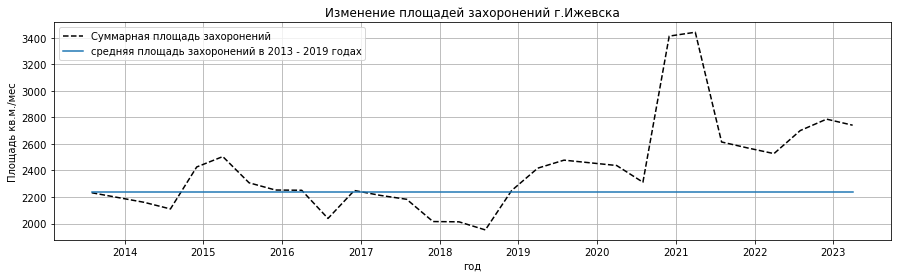

In [15]:
# преобразование индекса в формат datetime с использованием to_timestamp
downsampled_data.index = downsampled_data.index.to_timestamp()

# построение графика
plt.figure(figsize=(15, 4))
plt.plot(downsampled_data.index, downsampled_data['sum_area_month'], label='Суммарная площадь захоронений', linestyle='--', color='black')
plt.plot(downsampled_data.index, downsampled_data['mean_area_2013_2019'], label='средняя площадь захоронений в 2013 - 2019 годах')
plt.xlabel('год')
plt.ylabel('Площадь кв.м./мес')
plt.title('Изменение площадей захоронений г.Ижевска')
plt.legend()
plt.grid(True)
plt.show()

На графике отчётливо наблюдается резкий рост числа захоронений в период с июня 2020 года по июнь 2021 с дальнейшим плавным снижением в сторону средних значений. Превышение смертности в этот период составляло до 50% среднего числа ежемесячных захоронений в период 2013-2019 годы.

С начала 2022 года наблюдается новый тренд роста числа зарорнений. Превышение смертности относительно средних значений в период 2013 - 2019 годы составляет около 25% среднего числа ежемесячных захоронений в период 2013-2019 годы.

Превышение уровня смертности в 2019 - 2020 годах ("горка"), вероятнее всего связана с особенностями интерполяции, в связи с отсутствием спутниковых фотографий в период июля 2018 - май 2020 года.

Проведём количественную оценку превышения числа захоронений в  период с 2020-05 по 2022-01

In [16]:
# рассмотрим данные за период июнь 2020 - январь 2022 года
data_sum1 = data_sum['2020-05':'2022-01']

# избыточная площадь захоронений за данный период
delta_covid = data_sum1['sum_area_month'].sum() - mean_area_2013_2019*20
print('Избыточная площадь захоронений в период 2020-05 по 2022-01 составляет', round(delta_covid), 'кв.м.')
print(round(delta_covid/(2.2*2.5)),'- эквивалентное число захоронений')

Избыточная площадь захоронений в период 2020-05 по 2022-01 составляет 15309 кв.м.
2783 - эквивалентное число захоронений


Таким образом, избыточная площадь захоронений (относительно 2013 - 2019 года) составила 15309 кв.м. за период с мая 2020 по январь 2022 года, что эквивалентно* 2783 дополнительным захоронениям.

Данная оценка не учитывает возможные захоронения могила в могилу, с учетом которой общее количество захоронений может быть выше

(*) -  с учетом некоторых допущений